# Baybayin Character Recognition Project

## 1. Setting up environment

In [1]:
# Connect to Google Drive
from google.colab import drive
from pathlib import Path

drive.mount("/content/drive")

Mounted at /content/drive


In [6]:
# Get kaggle.json
import os
from importlib.metadata import distribution, PackageNotFoundError


# Check if we need to download kaggle
try:
  dist = distribution("kaggle")
  print(f"[INFO] {dist.name} ({dist.version}) already exists, skipping download...")
except PackageNotFoundError:
  print(f"kaggle package not found. installing...")
  !pip install kaggle # install kaggle if needed
  dist = distribution("kaggle")
  print(f"[INFO] Successfully installed {dist.name} ({dist.version})!")

# Set up kaggle credentials
if not os.path.isdir(Path.home() / ".kaggle"):
  ! mkdir ~/.kaggle
else:
  print(f"[INFO] {Path.home()}/.kaggle directory already exists.")

print(f"[INFO] Setting up kaggle credentials...")
! cp /content/drive/MyDrive/Grad\ School/project-baybayin/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
print(f"[INFO] Kaggle authentication configured!")

[INFO] kaggle (1.7.4.5) already exists, skipping download...
[INFO] /root/.kaggle directory already exists.
[INFO] Setting up kaggle credentials...
[INFO] Kaggle authentication configured!


In [7]:
# Create data folder
from pathlib import Path

BASE_DIR = Path("/content")
data_dir = BASE_DIR / "data"

if data_dir.is_dir():
  print(f"[INFO] {data_dir} already exists, will use existing directory...")
else:
  print(f"[INFO] Creating {data_dir} ...")
  data_dir.mkdir(parents=True, exist_ok=True)
  print(f"[INFO] Done!")

[INFO] /content/data already exists, will use existing directory...


## 2. Downloading data

In [8]:
# Download data
!kaggle datasets download danielhammond/baybayin-character-dataset -p /content/data

Dataset URL: https://www.kaggle.com/datasets/danielhammond/baybayin-character-dataset
License(s): apache-2.0
 93% 371M/397M [00:00<00:00, 519MB/s]
100% 397M/397M [00:02<00:00, 153MB/s]


In [9]:
# Unzip data file
import zipfile
zipped_data = "/content/data/baybayin-character-dataset.zip"

with zipfile.ZipFile(zipped_data, 'r') as zip_ref:
  zip_ref.extractall(data_dir)

## 3. Creating a Dataset class

In [10]:
# Import libraries
import os
import torch
import torchvision

import matplotlib.pyplot as plt

from PIL import Image
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from typing import Dict, List, Tuple

In [11]:
# Create Dataset class

class BaybayinDataset(Dataset):
  # Init func
  def __init__(self, data_path, transform=None):
    self.paths = list(Path(dataset_path).glob('*/*.[jJ][pP][gG]'))
    self.classes, self.class_to_idx = self.find_classes(data_path=data_path)
    self.transform = transform

  # Override __len__
  def __len__(self):
    return len(self.paths)

  # Override __getitem__
  def __getitem__(self, idx):
    image = self.load_image(idx)
    img_class = self.paths[idx].parent.name
    img_class_idx = self.class_to_idx[img_class]

    # Transform if necessary
    if self.transform:
      return self.transform(image), img_class_idx
    else:
      return image, img_class_idx


  # Helper class to find classes
  def find_classes(self, data_path: str) -> Tuple[List[str], Dict[int, str]]:
    """ Find classes given a folder containing subfolders of data. """
    # 1. Get class names
    classes = sorted([entry.name for entry in os.scandir(data_path) if entry.is_dir()])

    # 2. Raise error if no class names
    if not classes:
      raise FileNotFoundError(f"No classes found in {data_path}. Please check file structure.")

    # 3. Get a dictionary of class names
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}

    return classes, class_to_idx

  # Helper function to load image
  def load_image(self, index):
    image_path = self.paths[index]
    return Image.open(image_path)

### 3.1 Creating BaybayinDataset instance

In [12]:
dataset_path = data_dir / 'Baybayin Character Dataset' / 'Grouped'
dataset_path

PosixPath('/content/data/Baybayin Character Dataset/Grouped')

In [13]:
# Set up data transform (no data preprocessing)
transform = transforms.Compose([
    transforms.Resize(size=(32, 32)), # The input is 32x32 image
    transforms.Grayscale(),
    transforms.ToTensor()
])

In [14]:
# Create dataset without transforms
dataset = BaybayinDataset(data_path=dataset_path, transform=transform)

### 3.2 Visualize dataset images

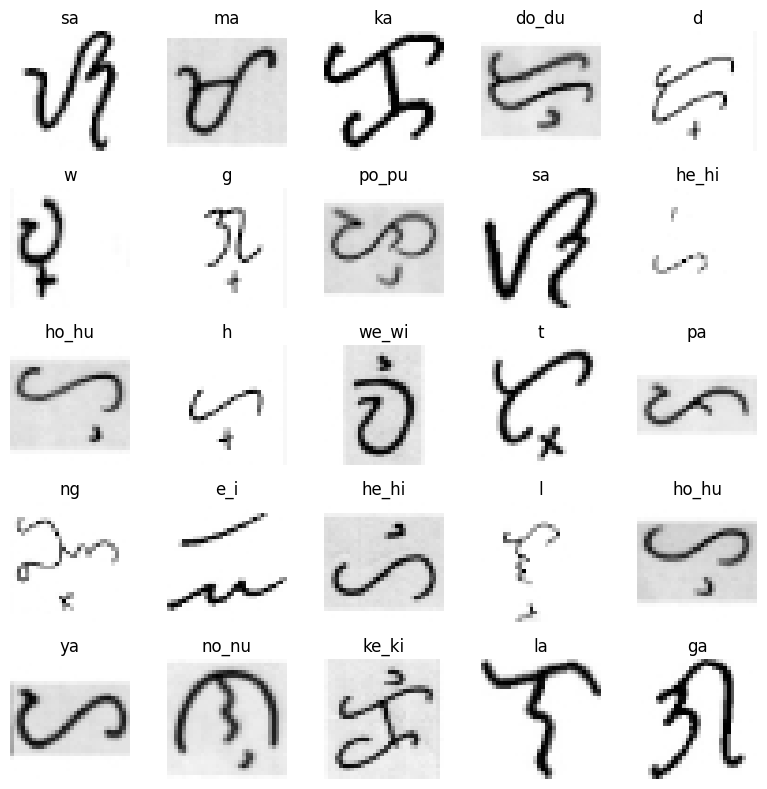

In [15]:
import random

def plot_random_images(data_set=dataset, n=25, nrows=5, ncols=5):
  # Set up figure
  plt.figure(figsize=(8,8))

  # Get class names
  class_names = dataset.classes

  # Start loop
  for i in range(1, n+1):

    # Get random image
    rand_idx = random.randint(0, len(dataset))
    rand_img, rand_img_class = dataset.__getitem__(rand_idx)

    # Plot image
    plt.subplot(nrows, ncols, i)
    plt.imshow(rand_img.permute(1, 2, 0), cmap='gray')
    plt.title(class_names[rand_img_class])
    plt.axis(False)

  plt.tight_layout()
  plt.show()

plot_random_images()

### 3.3 Create training and testing data

In [16]:
# Define function to set seeds
def set_seeds(seed:int=17):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

In [17]:
import numpy as np
from sklearn.model_selection import train_test_split

# Define variables
SAMPLES_PER_CLASS = 1000

# Get classes
classes = dataset.classes
# Create indices for each data
indices = np.arange(len(dataset))

# Create matching class list
class_list = []
for i in range(len(classes)):
  class_list.extend([i]*SAMPLES_PER_CLASS)

# Create split
train_indices, test_indices = train_test_split(
    indices,
    test_size=0.2,
    stratify=class_list
)

len(train_indices), len(test_indices)

(47200, 11800)

Check if startification worked

In [18]:
import pandas as pd
test_index_classes = [class_list[i] for i in test_indices]
df = pd.DataFrame({
    'index': test_indices,
    'class': test_index_classes
})
df.value_counts('class')

,count
class,
0,200
1,200
2,200
3,200
4,200
5,200
6,200
7,200
8,200


In [19]:
train_index_classes = [class_list[i] for i in train_indices]
df = pd.DataFrame({
    'index': train_indices,
    'class': train_index_classes
})
df.value_counts('class')

,count
class,
0,800
1,800
2,800
3,800
4,800
5,800
6,800
7,800
8,800


### 3.4. Create dataloaders

In [20]:
# Create data subsets
from torch.utils.data import DataLoader, Subset

train_subset = Subset(dataset, train_indices)
test_subset = Subset(dataset, test_indices)

In [21]:
# Create dataloaders
BATCH_SIZE = 64
NUM_WORKERS = os.cpu_count()

train_loader = DataLoader(
    train_subset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS)

test_loader = DataLoader(
    test_subset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS)

print(f'There are {len(train_loader)} batches of size {BATCH_SIZE} for training.')
print(f'There are {len(test_loader)} batches of size {BATCH_SIZE} for testing.')


There are 738 batches of size 64 for training.
There are 185 batches of size 64 for testing.


In [22]:
# Get torch shape [B, C, H, W]
next(iter(train_loader))[0].shape

torch.Size([64, 1, 32, 32])

## 4. The CNN Model

### 4.1 Create CNN architecture
based on the LeNet 5 architecture - https://ieeexplore.ieee.org/document/726791

In [23]:
# Based on the LeNet 5 architecture
from torch import nn

class BaybayinClassifier(nn.Module):
  def __init__(self,
               input_shape:int=1,
               output_shape:int=len(classes)):
    super().__init__()

    self.feature_extractor = nn.Sequential(
        # C1 - Convolutional Layer
        nn.Conv2d(in_channels=input_shape, out_channels=6, kernel_size=5,stride=1),
        nn.BatchNorm2d(num_features=6),
        nn.Tanh(),

        # S2 - Subsampling Layer
        nn.AvgPool2d(kernel_size=2, stride=2),

        # C3 - Convolutional Layer
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, groups=2),
        nn.BatchNorm2d(num_features=16),
        nn.Tanh(),

        # S4 - Subsampling Layer
        nn.AvgPool2d(kernel_size=2, stride=2),

        # C5 - Convolutional Layer
        nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1)
    )

    self.classifier_head = nn.Sequential(
        nn.Flatten(),
        #FC6 - Fully Connected Layer
        nn.Linear(in_features=120, out_features=84),
        nn.Tanh(),
        nn.Linear(in_features=84, out_features=output_shape),
        nn.Softmax(dim=1)
    )

  def forward(self, x):
    return self.classifier_head(self.feature_extractor(x))
    # return self.feature_extractor(x)

In [24]:
# Create model instance
set_seeds()
model = BaybayinClassifier()

In [25]:
# Check model summary
try:
  from torchinfo import summary
except:
  print(f'[INFO] Could not find torchinfo, downloading...')
  ! pip install -q torchinfo
  from torchinfo import summary
  print(f'[INFO] Successfully downloaded torchinfo!')

summary(model,
        input_size=[32, 1, 32, 32],
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

[INFO] Could not find torchinfo, downloading...
[INFO] Successfully downloaded torchinfo!


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
BaybayinClassifier (BaybayinClassifier)  [32, 1, 32, 32]      [32, 59]             --                   True
├─Sequential (feature_extractor)         [32, 1, 32, 32]      [32, 120, 1, 1]      --                   True
│    └─Conv2d (0)                        [32, 1, 32, 32]      [32, 6, 28, 28]      156                  True
│    └─BatchNorm2d (1)                   [32, 6, 28, 28]      [32, 6, 28, 28]      12                   True
│    └─Tanh (2)                          [32, 6, 28, 28]      [32, 6, 28, 28]      --                   --
│    └─AvgPool2d (3)                     [32, 6, 28, 28]      [32, 6, 14, 14]      --                   --
│    └─Conv2d (4)                        [32, 6, 14, 14]      [32, 16, 10, 10]     1,216                True
│    └─BatchNorm2d (5)                   [32, 16, 10, 10]     [32, 16, 10, 10]     32                   True
│    └─Tanh (6)   

## 5. Train/test

### 5.1. Create `train` and `test` steps

In [26]:
# Training step
def train_step(model: torch.nn,
               train_loader: torch.utils.data.DataLoader,
               criterion: torch.nn,
               opt: torch.optim,
               device: torch.device,
               epochs:int):
  """ Trains a given model for one epoch. """
  # Define loss and acc
  train_loss, train_acc = 0, 0

  # Set model to train mode
  model.train()


  # Loop through dataloader
  for batch, (X, y) in enumerate(train_loader):
    # Send data to device
    X, y = X.to(device), y.to(device)

    # Make pred
    y_logits = model(X)
    y_preds = torch.argmax(y_logits, dim=1)
    loss = criterion(y_logits, y)
    train_loss += loss.item()

    # Gradient descent
    opt.zero_grad()
    loss.backward()
    opt.step()

    # Get accuracy
    acc = (y_preds == y).sum().item() / len(y)
    train_acc += acc

  # Get average loss and acc
  train_loss /= len(train_loader)
  train_acc /= len(train_loader)

  return train_loss, train_acc

In [27]:
# Testing step
def test_step(model: torch.nn,
              test_loader: torch.utils.data.DataLoader,
              criterion: torch.nn,
              device: torch.device):
  """ Evaluates a model performance given testing data. """
  # Initialize loss and acc
  test_loss, test_acc = 0, 0

  # Turn model to predict mode
  model.eval()
  with torch.inference_mode():
    for batch, (X, y) in enumerate(test_loader):
      X, y = X.to(device), y.to(device)

      y_logits = model(X)
      y_preds = torch.argmax(y_logits, dim=1)
      loss = criterion(y_logits, y)
      test_loss += loss.item()

      acc = (y_preds == y).sum().item() / len(y)
      test_acc += acc

  test_loss /= len(test_loader)
  test_acc /= len(test_loader)

  return test_loss, test_acc

### 5.2. Define a training loop function

In [28]:
# Training loop
from tqdm.auto import tqdm
from torch.optim import lr_scheduler

def train(model: torch.nn,
          train_loader: torch.utils.data.DataLoader,
          test_loader: torch.utils.data.DataLoader,
          criterion: torch.nn,
          opt: torch.optim,
          device: torch.device,
          epochs:int=5):
  """ Performs a train/test loop on a model for certain number of epochs. """
  # Send model to device
  model.to(device)

  # Create a results dictionary
  results = {
      'train_loss': [],
      'train_acc': [],
      'test_loss': [],
      'test_acc': []
  }

  # Create learning rate scheduler
  scheduler = lr_scheduler.StepLR(optimizer=opt, step_size=10, gamma=0.1)

  # Perform train-test loop
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model, train_loader, criterion, opt, device, epochs)
    test_loss, test_acc = test_step(model, test_loader, criterion, device)

    # Update learning rate
    scheduler.step()

    # Print results
    print(f"Epoch {epoch+1}| "
          f"Train loss: {train_loss:.4f} | "
          f"Train acc: {train_acc:.4f} | "
          f"Test loss: {test_loss:.4f} | "
          f"Test acc: {test_acc:.4f}"
    )

    # Store results
    results['train_loss'].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
    results['train_acc'].append(train_acc.item() if isinstance(train_acc,torch.Tensor) else train_acc)
    results['test_loss'].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
    results['test_acc'].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

  return results

### 5.3 Train model with baseline hyperparameters

In [29]:
# Set up device-agnostic code
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [30]:
# Create model instance
set_seeds()
model = BaybayinClassifier()

In [31]:
# Criterion and optimizer
criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [32]:
from timeit import default_timer as timer
start_time = timer()
results = train(model, train_loader, test_loader, criterion, opt, device, epochs=10)
end_time = timer()

print(f"Total training timer: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1| Train loss: 3.5639 | Train acc: 0.6075 | Test loss: 3.3910 | Test acc: 0.7529
Epoch 2| Train loss: 3.3241 | Train acc: 0.8142 | Test loss: 3.3915 | Test acc: 0.7632
Epoch 3| Train loss: 3.2699 | Train acc: 0.8559 | Test loss: 3.5768 | Test acc: 0.5645
Epoch 4| Train loss: 3.2353 | Train acc: 0.8880 | Test loss: 3.2880 | Test acc: 0.8516
Epoch 5| Train loss: 3.2033 | Train acc: 0.9174 | Test loss: 3.3004 | Test acc: 0.8341
Epoch 6| Train loss: 3.1935 | Train acc: 0.9243 | Test loss: 3.3165 | Test acc: 0.8178
Epoch 7| Train loss: 3.1823 | Train acc: 0.9343 | Test loss: 3.2533 | Test acc: 0.8736
Epoch 8| Train loss: 3.1762 | Train acc: 0.9393 | Test loss: 3.2870 | Test acc: 0.8465
Epoch 9| Train loss: 3.1724 | Train acc: 0.9417 | Test loss: 3.3172 | Test acc: 0.8129
Epoch 10| Train loss: 3.1704 | Train acc: 0.9435 | Test loss: 3.4191 | Test acc: 0.7096
Total training timer: 199.558 seconds


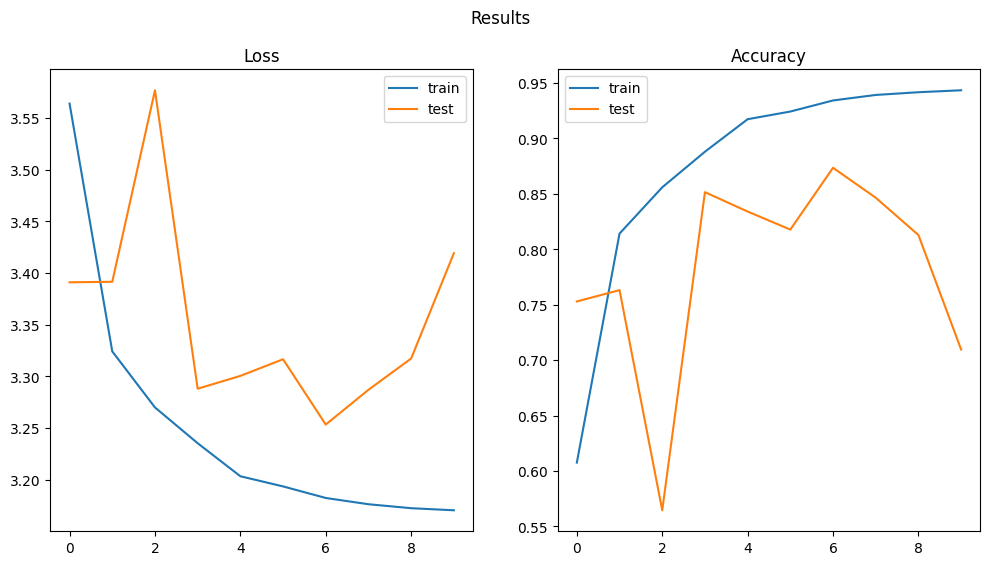

In [33]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(results['train_loss'], label='train')
plt.plot(results['test_loss'], label='test')
plt.title('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(results['train_acc'], label='train')
plt.plot(results['test_acc'], label='test')
plt.title('Accuracy')
plt.legend()

plt.suptitle('Results')
plt.show()

## 6. Predict and plot images

In [34]:
# Write a function that will return the predictions, truth labels, and data.

def predict(model: torch.nn.Module,
            test_loader: torch.utils.data.DataLoader,
            device: torch.device) -> Tuple[List[torch.Tensor], List[int], List[int]]:
  """ Make predictions from a test set using a model.

  Args:
    model
      A PyTorch model used for prediction
    test_set
      A PyTorch DataLoader containing the test dataset.
    device
      A PyTorch device where the model and data resides.

  Returns:
    A Tuple of the test data, ground truth labels, prediction labels and score.
    In the form of:
      data, truth_labels, pred_labels, score
  """
  # Initialize lists
  data = []
  truth_labels = []
  pred_labels = []
  score = []

  # Send model to device
  model.to(device)

  # Turn model to eval mode
  model.eval()
  with torch.inference_mode():
    for X, y in test_loader:
      X, y = X.to(device), y.to(device)

      scores = model(X).softmax(dim=1)
      predictions = scores.argmax(dim=1)
      # print(scores)
      scores = torch.gather(scores, 1, predictions.unsqueeze(1)).squeeze(1)
      # print(predictions.unsqueeze(0).shape)

      # Append to list
      data.append(X)
      truth_labels.append(y)
      pred_labels.append(predictions)
      score.append(scores)

    # Concatenate results and convert to cpu for numpy processing
    data = torch.cat(data, dim=0).cpu()
    truth_labels = torch.cat(truth_labels, dim=0).cpu().numpy()
    pred_labels = torch.cat(pred_labels, dim=0).cpu().numpy()
    score = torch.cat(score, dim=0).cpu().numpy()

  return data, truth_labels, pred_labels, score

In [35]:
# Make predictions
data, truth_labels, pred_labels, score = predict(model, test_loader, device)
len(data), len(truth_labels), len(pred_labels), len(score)

(11800, 11800, 11800, 11800)

Text(0.5, 1.0, 'Confusion Matrix')

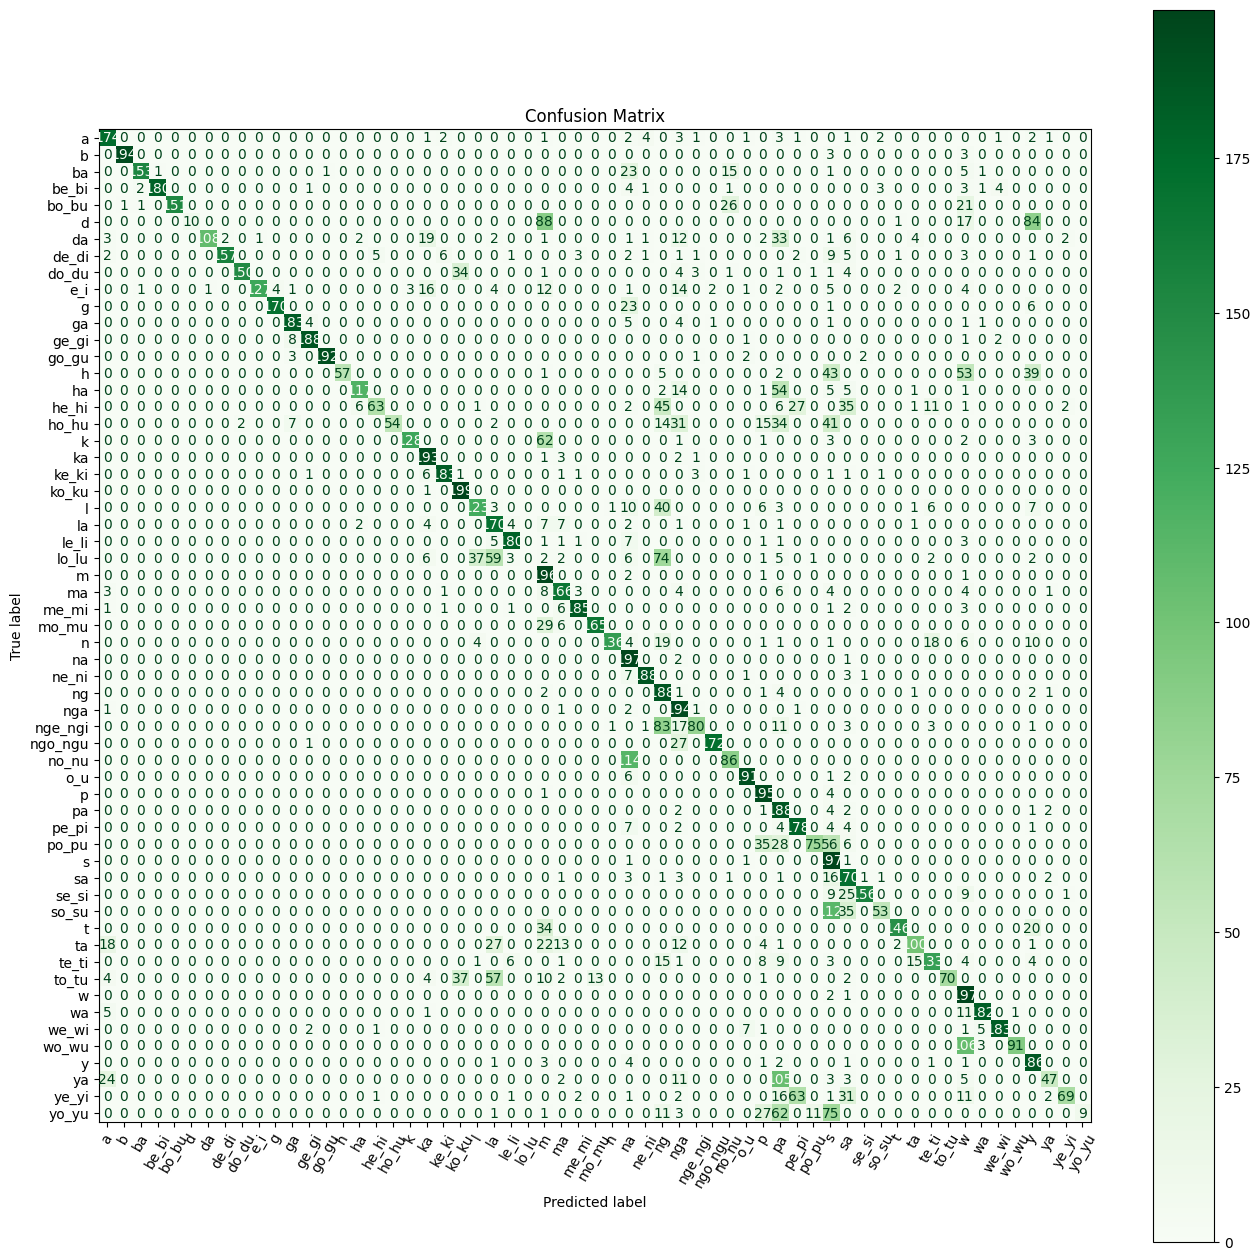

In [41]:
# Plot a confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(truth_labels[], pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=dataset.classes)

# plt.figure(figsize=(16,16))
disp.plot(cmap='Greens',xticks_rotation=60)
disp.ax_.figure.set_size_inches(16, 16)
disp.ax_.set_title('Confusion Matrix')